In [ ]:
! pip -q install git+https://github.com/qubvel/segmentation_models.pytorch

     |████████████████████████████████| 61kB 5.8MB/s 
     |████████████████████████████████| 225kB 13.4MB/s 


In [ ]:
import segmentation_models_pytorch as smp
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from google.colab import drive
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import albumentations as A
import torch.nn.functional as F
import pandas as pd
import nibabel as nib
from tqdm import tqdm

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Extract dataset

In [ ]:
! unzip -q '/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData.zip'

In [ ]:
! ls MICCAI_BraTS2020_TrainingData/ | head -5

BraTS20_Training_001
BraTS20_Training_002
BraTS20_Training_003
BraTS20_Training_004
BraTS20_Training_005


In [ ]:
! ls MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/

BraTS20_Training_001_flair.nii.gz  BraTS20_Training_001_t1.nii.gz
BraTS20_Training_001_seg.nii.gz    BraTS20_Training_001_t2.nii.gz
BraTS20_Training_001_t1ce.nii.gz


In [ ]:
root = './MICCAI_BraTS2020_TrainingData'
data = pd.read_csv(os.path.join(root, 'name_mapping.csv'))
data.head(5)

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,BraTS20_Training_001
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,BraTS20_Training_002
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,BraTS20_Training_003
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,BraTS20_Training_004
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,BraTS20_Training_005


In [ ]:
imgpath = {
    'seg': [],    
    't1': [],
    't1ce': [],
    't2': [],
    'flair': []
}

# load image paths in dictionary
for x in data['BraTS_2020_subject_ID']:
    patient=os.path.join(root,x)
    for name in imgpath:
      imgpath[name].append(os.path.join(patient, x+f'_{name}.nii.gz'))
imgpath['seg'][:5]

['./MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz',
 './MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_seg.nii.gz',
 './MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_seg.nii.gz',
 './MICCAI_BraTS2020_TrainingData/BraTS20_Training_004/BraTS20_Training_004_seg.nii.gz',
 './MICCAI_BraTS2020_TrainingData/BraTS20_Training_005/BraTS20_Training_005_seg.nii.gz']

In [ ]:
def loadimg(imgpath):
  return nib.load(imgpath).get_fdata()

def cropcentre(imgslice,cropx,cropy):
  y,x = imgslice.shape
  startx = x//2-(cropx//2)
  starty = y//2-(cropy//2)    
  return imgslice[starty:starty+cropy,startx:startx+cropx]

def normalizeslice(imgslice):
  return (imgslice-imgslice.mean()) / imgslice.std()

In [ ]:
! mkdir dataset
! mkdir dataset/t1
! mkdir dataset/t1ce
! mkdir dataset/t2
! mkdir dataset/flair
! mkdir dataset/seg

In [ ]:
numOfImgsSaved = 0
imgs = {}
imgslice = {}
numOfImgsToSave = 2000

for i in (range(len(imgpath['seg']))):
    for name in imgpath:
      imgs[name] = loadimg(imgpath[name][i])
    
    for j in range(155):
        for name in imgs:
          imgslice[name] = imgs[name][:,:,j]
          imgslice[name] = cropcentre(imgslice[name], 128, 128)

        if imgslice['seg'].max() > 0:
          for name in ['t1','t2','t1ce','flair']:
            imgslice[name] = normalizeslice(imgslice[name])
          for name in imgslice:
            np.save(f'./dataset/{name}/img_{numOfImgsSaved}.npy', imgslice[name])
          numOfImgsSaved += 1
        
        if numOfImgsSaved == numOfImgsToSave:
          break
    if numOfImgsSaved == numOfImgsToSave:
          break

In [ ]:
! du -h dataset

258M	dataset/flair
258M	dataset/t2
258M	dataset/t1
258M	dataset/t1ce
258M	dataset/seg
1.3G	dataset


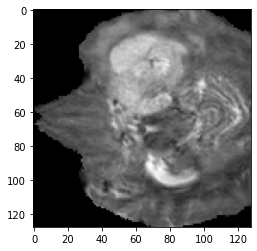

In [ ]:
x = np.load('dataset/t2/img_25.npy')
plt.imshow(x, cmap='gray')

# Dataset

In [ ]:
class Dataset(Dataset):
    def __init__(self, datapath='./dataset/', augmentation=None):
        self.augmentation = augmentation
        self.folderpaths = {
            'mask': os.path.join(datapath, 'seg/'),
            't1': os.path.join(datapath, 't1/'),
            't1ce': os.path.join(datapath, 't1ce/'),
            't2': os.path.join(datapath, 't2/'),
            'flair': os.path.join(datapath, 'flair/')
        }
    
    def __getitem__(self, idx):
        images = {}
        for name in self.folderpaths:
          images[name] = np.load(os.path.join(self.folderpaths[name], f'img_{idx}.npy'))

        if self.augmentation:
          images = self.augmentation(image=images['flair'],
                                      mask=images['mask'],
                                      t1=images['t1'],
                                      t1ce=images['t1ce'],
                                      t2=images['t2'])
          images['flair'] = images['image']

        for name in images:
          images[name] = torch.from_numpy(images[name])

        # stack modalities
        input = torch.stack([images['t1'],
                             images['t1ce'],
                             images['t2'],
                             images['flair']], dim=0)
        
        # map pixels with value of 4 to 3
        images['mask'][images['mask']==4] = 3

        # one-hot encode truth label
        images['mask'] = F.one_hot(images['mask'].long().unsqueeze(0), num_classes = 4).permute(0,3,1,2).contiguous().squeeze(0)

        return input.float(), images['mask'].long()
    
    def __len__(self):
        return len(os.listdir(self.folderpaths['mask'])) - 1

In [ ]:
augmentation = A.Compose([
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5)                  
        ], p=0.8),
    A.RandomBrightnessContrast(p=0.8),
    ], 
    additional_targets={'t1':'image',
                          't1ce':'image',
                          't2':'image'})

valid_test_dataset = Dataset(datapath='./dataset/',
                             augmentation=None)

train_dataset = Dataset(datapath='./dataset/',
                        augmentation=augmentation)

# take 60%/20%/20% of the dataset for train/val/test 
train_length=int(0.6 * len(valid_test_dataset))
valid_length = int(0.2 * len(valid_test_dataset))
test_length = len(valid_test_dataset) - train_length - valid_length

_, valid_dataset, test_dataset = torch.utils.data.random_split(valid_test_dataset, (train_length,valid_length,test_length), generator=torch.Generator().manual_seed(42))

train_dataset, _, _ = torch.utils.data.random_split(train_dataset, (train_length,valid_length,test_length), generator=torch.Generator().manual_seed(42))


train_loader= DataLoader(train_dataset,
                      batch_size=16,
                      num_workers=2,
                      shuffle=True)

valid_loader= DataLoader(valid_dataset,
                      batch_size=1,
                      num_workers=2,
                      shuffle=False)

test_loader= DataLoader(test_dataset,
                      batch_size=1,
                      num_workers=2,
                      shuffle=False)

In [ ]:
a,b=next(iter(train_loader))

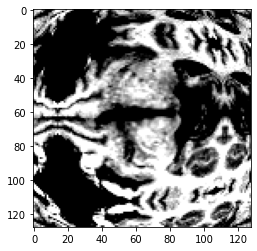

In [ ]:
plt.imshow(a[0,0],cmap='gray')

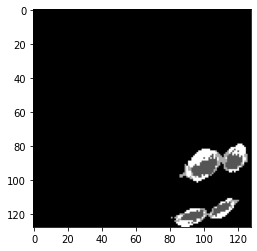

In [ ]:
bb = torch.argmax(b,1)
plt.imshow(bb[0],cmap='gray')

# Train Model

In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Tue Nov 24 11:52:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# import model
MODEL = smp.Unet(encoder_name='resnet50',
                 encoder_depth=5,
                 encoder_weights='imagenet',
                 decoder_channels=[1024,512,256,128,64],
                 in_channels=4,
                 classes=4,
                 activation=None)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
backgroundchannel = [0]

DICE_LOSS = smp.utils.losses.DiceLoss(activation='softmax2d')  

OPTIMIZER = torch.optim.Adam([ 
    dict(params=MODEL.parameters(), lr=0.0001),
])

METRICS = [
    smp.utils.metrics.IoU(threshold=0.5,
                          ignore_channels=backgroundchannel, 
                          activation='softmax2d'),
    smp.utils.metrics.Fscore(ignore_channels=backgroundchannel, 
                            activation='softmax2d'),
]

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model=MODEL,
    loss=DICE_LOSS,
    metrics=[],
    optimizer=OPTIMIZER,
    device=DEVICE,
    verbose=True
)
valid_epoch = smp.utils.train.ValidEpoch(
    model=MODEL,
    loss=DICE_LOSS,
    metrics=METRICS,
    device=DEVICE,
    verbose=True
)

max_dice_score = 0
stats = {
    'train_loss' : [],
    'valid_loss' : [],
    'fscore' : [],
    'iou_score' : []
}

for i in range(50):
  print(f'\n --- Epoch {i} --- ')
  train_logs = train_epoch.run(train_loader)
  valid_logs = valid_epoch.run(valid_loader)
  
  if max_dice_score < valid_logs['fscore']:
    max_dice_score = valid_logs['fscore']
    torch.save(MODEL.state_dict(), f'./model.pth')
    print('model saved!')
  
  # loss statistics
  stats['train_loss'].append(train_logs['dice_loss'])
  stats['valid_loss'].append(valid_logs['dice_loss'])

  # metric statistics
  stats['fscore'].append(valid_logs['fscore'])
  stats['iou_score'].append(valid_logs['iou_score'])
  np.save(f'./model.npy', stats)
  
  # reduce learning rate
  # if i == 40:
  #       OPTIMIZER.param_groups[0]['lr'] = 1e-5
  #       print('Decrease decoder learning rate to 1e-5!')
  


 --- Epoch 0 --- 
valid: 100%|██████████| 399/399 [00:09<00:00, 42.08it/s, dice_loss - 0.09278, iou_score - 0.3402, fscore - 0.4482]
model saved!

 --- Epoch 1 --- 
valid: 100%|██████████| 399/399 [00:08<00:00, 44.38it/s, dice_loss - 0.05945, iou_score - 0.3429, fscore - 0.4497]
model saved!

 --- Epoch 2 --- 
valid: 100%|██████████| 399/399 [00:09<00:00, 43.88it/s, dice_loss - 0.04607, iou_score - 0.4153, fscore - 0.526]
model saved!

 --- Epoch 3 --- 
valid: 100%|██████████| 399/399 [00:09<00:00, 43.56it/s, dice_loss - 0.0379, iou_score - 0.4586, fscore - 0.5725]
model saved!

 --- Epoch 4 --- 
valid: 100%|██████████| 399/399 [00:08<00:00, 45.33it/s, dice_loss - 0.03995, iou_score - 0.4308, fscore - 0.5562]

 --- Epoch 5 --- 
valid: 100%|██████████| 399/399 [00:08<00:00, 44.35it/s, dice_loss - 0.03192, iou_score - 0.487, fscore - 0.5967]
model saved!

 --- Epoch 6 --- 
valid: 100%|██████████| 399/399 [00:09<00:00, 44.04it/s, dice_loss - 0.03119, iou_score - 0.4911, fscore - 0.5962]


Text(0.5, 1.0, 'Train and Validation Loss')

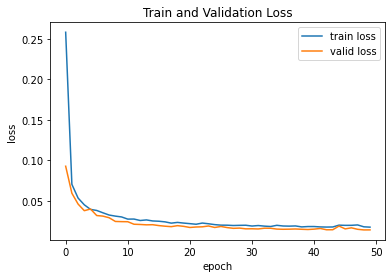

In [ ]:
STATS = np.load(f'./model.npy', allow_pickle='TRUE').item()
plt.plot(STATS['train_loss'], label='train loss')
plt.plot(STATS['valid_loss'], label='valid loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train and Validation Loss')

Text(0.5, 1.0, 'Fscore')

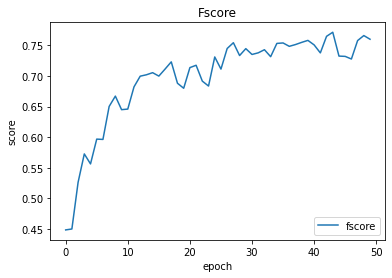

In [ ]:
STATS = np.load(f'./model.npy', allow_pickle='TRUE').item()
plt.plot(STATS['fscore'], label='fscore')
plt.legend(loc="lower right")
plt.ylabel('score')
plt.xlabel('epoch')
plt.title('Fscore')

# Test Model

In [ ]:
MODEL.load_state_dict(torch.load('./model.pth'))

<All keys matched successfully>

In [ ]:
subregions = {
    'all': [0],
    'ncr': [0,2,3],
    'ed': [0,1,3],
    'tc': [0,1,2],
}

for subregion in subregions:
  valid_epoch = smp.utils.train.ValidEpoch(
      model=MODEL,
      loss=DICE_LOSS,
      metrics=[smp.utils.metrics.Fscore(activation='softmax2d', ignore_channels=subregions[subregion])],
      device=DEVICE,
      verbose=False
  )
  valid_log = valid_epoch.run(test_loader)
  print(subregion, valid_log['fscore'])

all 0.753579033247942
ncr 0.765883906178054
ed 0.7375690557953963
tc 0.8066382903530135


# Single Scan


In [ ]:
! mkdir gifimg
! mkdir gifimg/t1
! mkdir gifimg/t1ce
! mkdir gifimg/t2
! mkdir gifimg/flair
! mkdir gifimg/seg

! mkdir gifimg/pred
! mkdir gifimg/label

In [ ]:
c=0
for i in range(1):
    for name in imgpath:
      imgs[name] = loadimg(imgpath[name][i])
    
    for j in range(155):
        for name in imgs:
          imgslice[name] = imgs[name][:,:,j]
          imgslice[name] = cropcentre(imgslice[name], 128, 128)
        
        if imgslice['flair'].max() == 0:
          continue
        imgslice['flair'] *= 255.0/imgslice['flair'].max()
        Image.fromarray(imgslice['flair']).convert('L').save(f'./gifimg/img_{c}.png')

        for name in ['t1','t2','t1ce','flair']:
          imgslice[name] = normalizeslice(imgslice[name])
        for name in imgslice:
          np.save(f'./gifimg/{name}/img_{c}.npy', imgslice[name])
        c+=1       

In [ ]:
gif_dataset = Dataset(datapath='./gifimg/',
                           augmentation=None)

gif_loader= DataLoader(gif_dataset,
                            batch_size=1,
                            num_workers=2,
                            shuffle=False)

subregions = {
    'all': [0],
    'ncr': [0,2,3],
    'ed': [0,1,3],
    'tc': [0,1,2],
}

for subregion in subregions:
  valid_epoch = smp.utils.train.ValidEpoch(
      model=MODEL,
      loss=DICE_LOSS,
      metrics=[smp.utils.metrics.Fscore(activation='softmax2d', ignore_channels=subregions[subregion])],
      device=DEVICE,
      verbose=False
  )
  valid_log = valid_epoch.run(gif_loader)
  print(subregion, valid_log['fscore'])

all 0.7634285470674628
ncr 0.8574606550685996
ed 0.7867721295528227
tc 0.7822529962950643


# Coronal/Sagittal View


In [ ]:
! mkdir coronal
! mkdir coronal/t1
! mkdir coronal/t1ce
! mkdir coronal/t2
! mkdir coronal/flair
! mkdir coronal/seg
! mkdir coronal/pred
! mkdir coronal/label

! mkdir sagittal
! mkdir sagittal/t1
! mkdir sagittal/t1ce
! mkdir sagittal/t2
! mkdir sagittal/flair
! mkdir sagittal/seg
! mkdir sagittal/pred
! mkdir sagittal/label

In [ ]:
# save a single patient scan of each coronal and sagittal view
c=0
for i in range(1):
    for name in imgpath:
      imgs[name] = loadimg(imgpath[name][i])
    
    for j in range(155):
        for name in imgs:
          imgslice[name] = imgs[name][:,j,:]
          imgslice[name] = cropcentre(imgslice[name], 128, 128)
        
        if imgslice['flair'].max() == 0:
          continue
        imgslice['flair'] *= 255.0/imgslice['flair'].max()
        Image.fromarray(imgslice['flair']).convert('L').save(f'./coronal/img_{c}.png')
        
        for name in ['t1','t2','t1ce','flair']:
          imgslice[name] = normalizeslice(imgslice[name])
        for name in imgslice:
          np.save(f'./coronal/{name}/img_{c}.npy', imgslice[name])
        c+=1
    c=0
    for j in range(155):
        for name in imgs:
          imgslice[name] = imgs[name][j,:,:]
          imgslice[name] = cropcentre(imgslice[name], 128, 128)
        
        if imgslice['flair'].max() == 0:
          continue
        imgslice['flair'] *= 255.0/imgslice['flair'].max()
        Image.fromarray(imgslice['flair']).convert('L').save(f'./sagittal/img_{c}.png')
        
        for name in ['t1','t2','t1ce','flair']:
          imgslice[name] = normalizeslice(imgslice[name])
        for name in imgslice:
          np.save(f'./sagittal/{name}/img_{c}.npy', imgslice[name])
        c+=1

In [ ]:
coronal_dataset = Dataset(datapath='./coronal/',
                           augmentation=None)

coronal_loader= DataLoader(coronal_dataset,
                            batch_size=1,
                            num_workers=2,
                            shuffle=False)

sagittal_dataset = Dataset(datapath='./sagittal/',
                           augmentation=None)

sagittal_loader= DataLoader(sagittal_dataset,
                            batch_size=1,
                            num_workers=2,
                            shuffle=False)

In [ ]:
subregions = {
    'all': [0],
    'ncr': [0,2,3],
    'ed': [0,1,3],
    'tc': [0,1,2],
}

print('--- Coronal ---')
for subregion in subregions:
  valid_epoch = smp.utils.train.ValidEpoch(
      model=MODEL,
      loss=DICE_LOSS,
      metrics=[smp.utils.metrics.Fscore(activation='softmax2d', ignore_channels=subregions[subregion])],
      device=DEVICE,
      verbose=False
  )
  valid_log = valid_epoch.run(coronal_loader)
  print(subregion, valid_log['fscore'])

print('--- Sagittal ---')
for subregion in subregions:
  valid_epoch = smp.utils.train.ValidEpoch(
      model=MODEL,
      loss=DICE_LOSS,
      metrics=[smp.utils.metrics.Fscore(activation='softmax2d', ignore_channels=subregions[subregion])],
      device=DEVICE,
      verbose=False
  )
  valid_log = valid_epoch.run(sagittal_loader)
  print(subregion, valid_log['fscore'])

--- Coronal ---
all 0.6163462499711597
ncr 0.7217872399673279
ed 0.6210562994581427
tc 0.7006740687405904
--- Sagittal ---
all 0.4002944199105503
ncr 0.6212393332121366
ed 0.40314447338433523
tc 0.4311018547446186


# Load model/statistics

In [ ]:
MODEL = smp.Unet(encoder_name='resnet50',
                 encoder_depth=5,
                 encoder_weights='imagenet',
                 decoder_channels=[1024,512,256,128,64],
                 in_channels=4,
                 classes=4,
                 activation=None)

MODEL.load_state_dict(torch.load(f'./model.pth'))
STATS = np.load(f'./model.npy', allow_pickle='TRUE').item()